In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# Reinforcement Learning

Reinforcement learning (RL) is an area of machine learning concerned with how software agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

Reinforcement learning differs from supervised learning in not needing labelled input/output pairs be presented, and leanring to act under evaluative feedback (rewards). Instead the focus is on finding a balance between exploration (of uncharted territory) and exploitation (of current knowledge).

The environment is typically stated in the form of a Markov decision process (MDP), because many reinforcement learning algorithms for this context utilize dynamic programming techniques. The main difference between the classical dynamic programming methods and reinforcement learning algorithms (that involve ANNs) is that the latter do not assume knowledge of an exact mathematical model of the MDP and they target large MDPs where exact methods become infeasible.

---

Reinforcement learning is *Agent-oriented learning*, that is learning by interacting with an environment to achieve a goal. Which is learning by trial and error, with only delayed evaluative feedback (reward).

However RL does have some challenges:
* We only have a reward signal as feedback
* Feedback is often delayed
* Time matters, sequential and non-stationary data
* Data received is affected by the agents previous interactions

It has been applied successfully to various problems, including robot control, power control, telecommunications, backgammon, checkers and Go.

## Problem formulation as a Markov Decision Process (MDP)

Often we consider the problem of making a sequence of good decisions. That is in a discrete setting, an agent will make sequence of **actions** $\{a_t\}$, observe a sequence of **observations** $\{o_t\}$ and receive a sequence of **rewards** $\{r_t\}$. We define the **history** at time $t$ to be $h_t = (a_1, o_1, r_1, \dots, a_t, o_t, r_t)$. The agent's function of the history, that is, $a_{t+1} = f(h_t)$, and the problem of sequential decision making can be thought of as defining and computing the function $f$ appropriately.

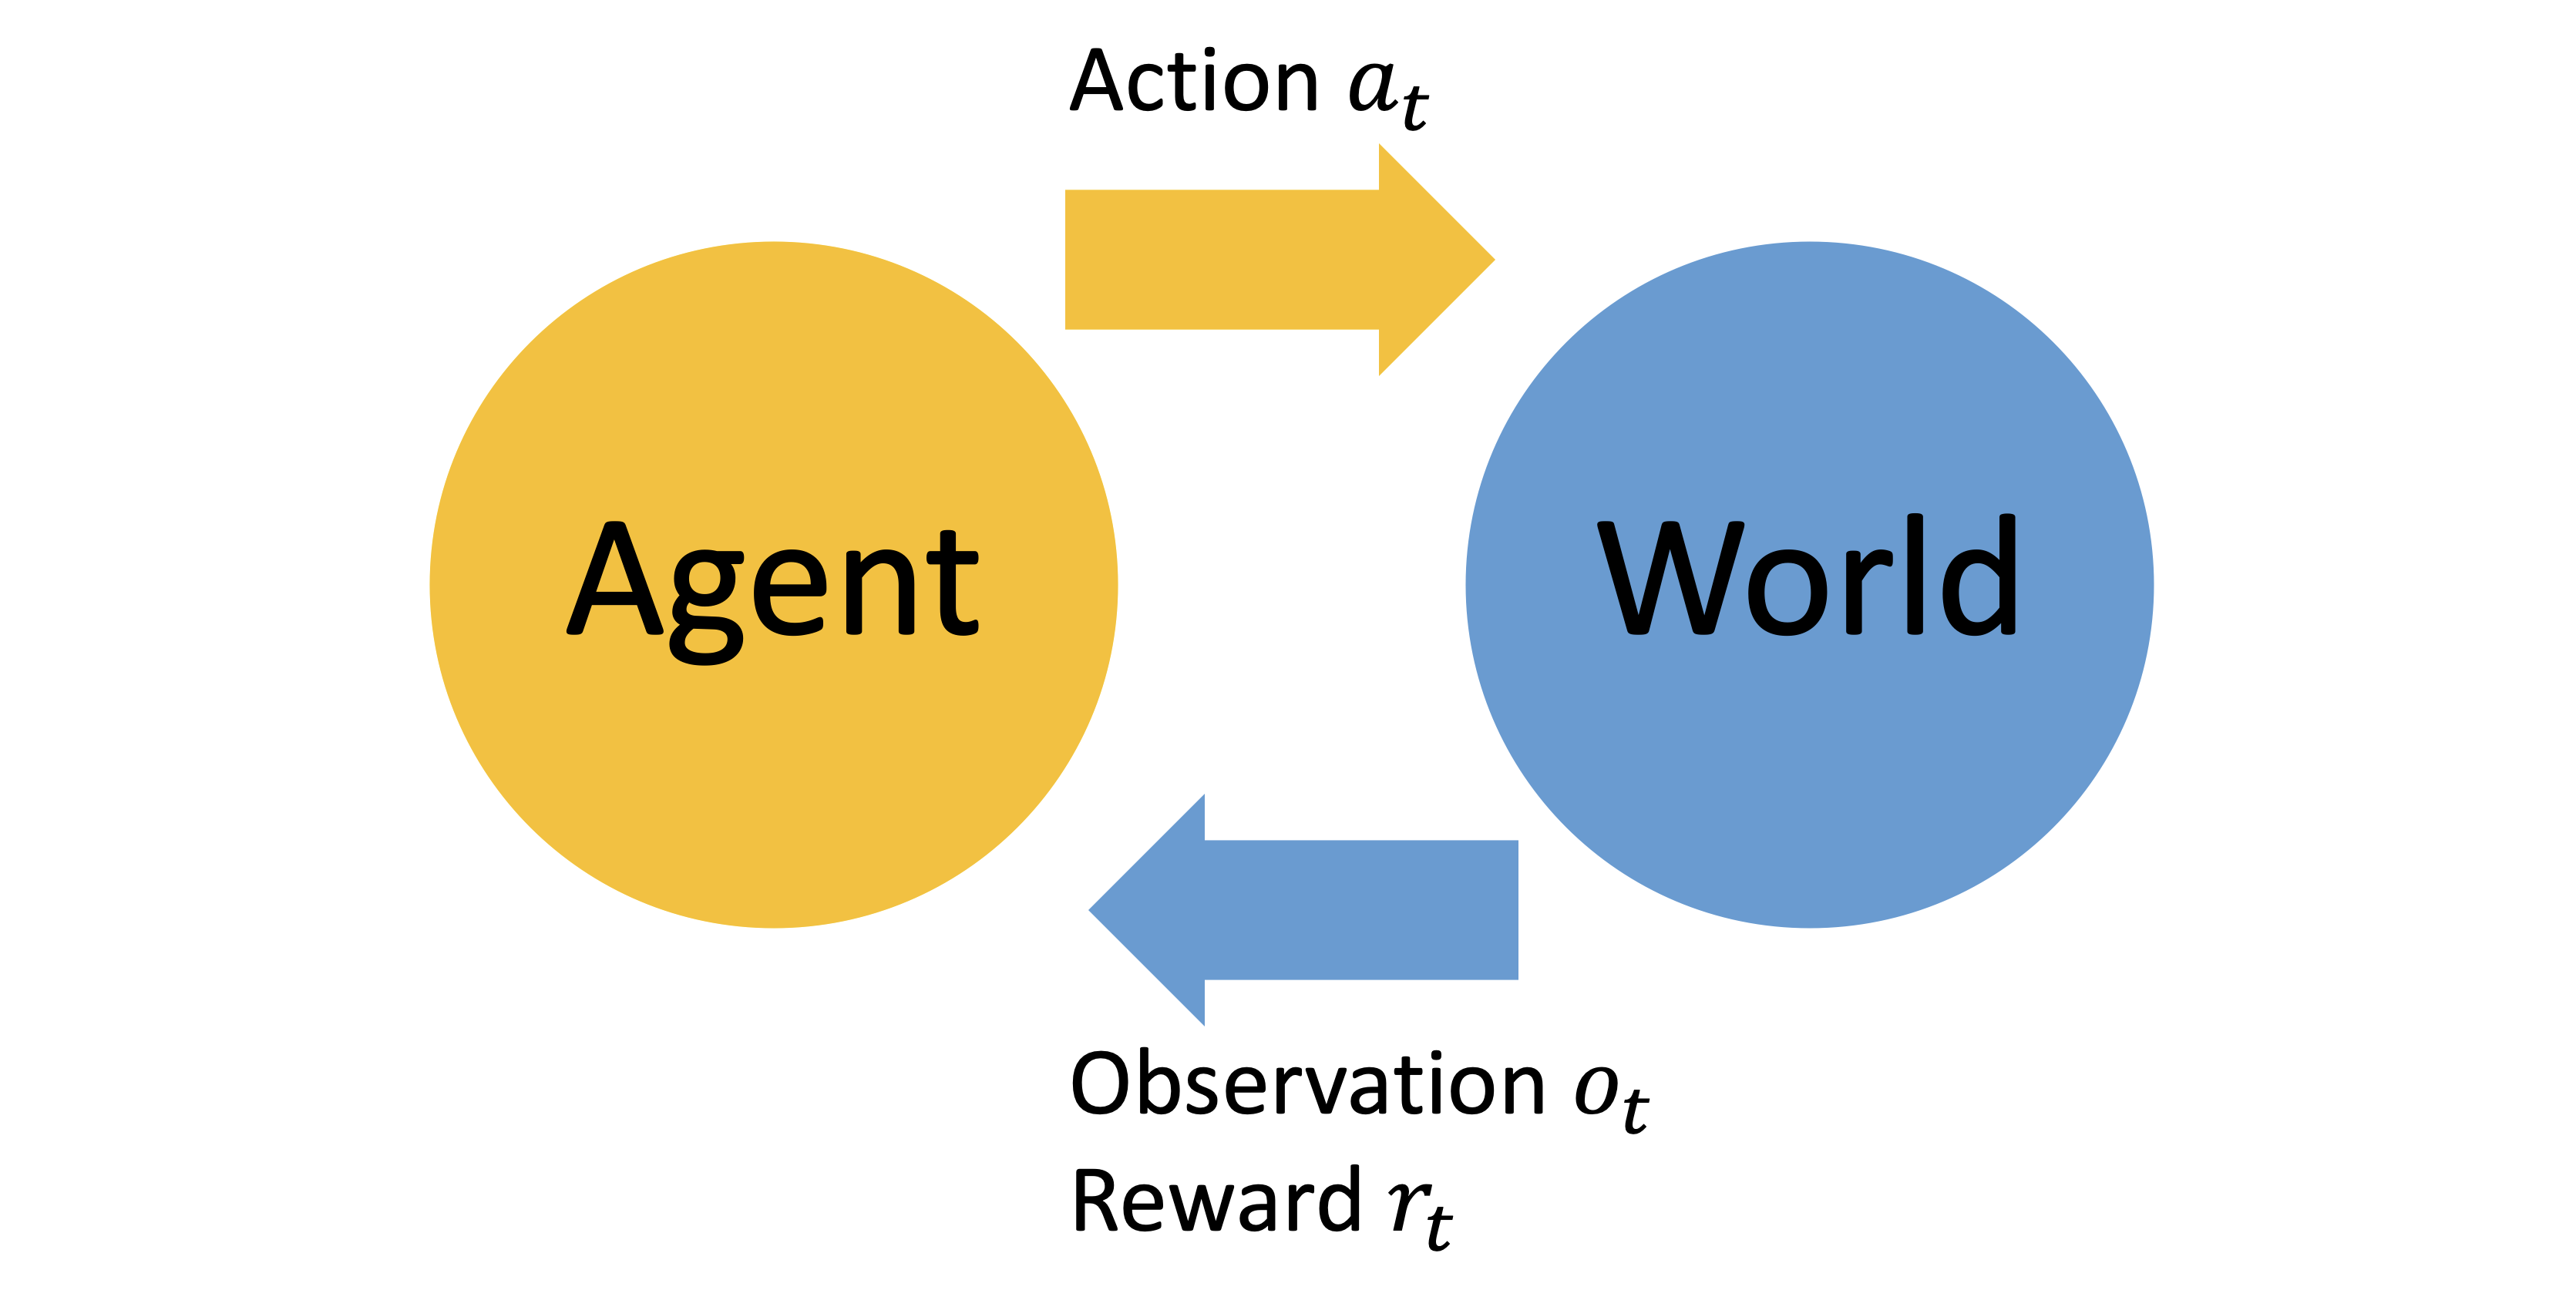


At each step $t$ the agent (as illustrated above) executes action $a_t$, receives observation $o_t$ and receives a scalar reward $r_t$. The environment receives action $a_t$, emits observation $o_{t+1}$ and emits a scalar reward $r_{t+1}$.

Our world may be in a state of possible states ($S$), however the agent observes a sequence of states $\{s_t\}$. We often want to consider the **transition dynamics** of the world $P(s_{t+1}|s_t,a_t,\dots,s_1,a_1)$, a probability distribution over $S$ conditioned on the previous states and actions. In RL, we often assume the **Markov property** that

$$ P(s_{t+1}|s_t,a_t,\dots,s_1,a_1)=P(s_{t+1}|s_t,a_t) $$

We can use the trick to make sure the Markov property holds, by using the history $h_t$ as our state. Usually, we consider the reward $r_t$ to be received on the transition between states, $s_t \xrightarrow{a_t} s_{t+1}$. A reward function is used to predict rewards, $R(s, a, s′) = \mathop{\mathbb{E}}[r_t|s_t = s, a_t = a, s+{t+1} = s′]$. We will often consider the reward function to be of the form $R(s) = \mathop{\mathbb{E}}[r_t|s_t = s]$ or $R(s, a) = \mathop{\mathbb{E}}[r_t|s_t = s, a_t = a]$. A **model** consists of the above transition dynamics and reward function.

The **agent state** is a function of the history, $s^a_t = g(h_t)$, a RL agent typically has an explicit representation of one or more of the following three things, a policy, a value function and optionally a model. A **policy** $\pi$ is a mapping from the agent state to an action, $\pi(s^a_t)\in A$,
or, sometimes it is a stochastic distribution over actions $\pi(a_t|s^a_t)$. When the agent wants to take an action and $\pi$ is stochastic, it picks action $a \in A$ with probability $P(a_t = a) = \pi(a|s^a_t)$. Given a policy $\pi$ and discount factor $\gamma \in [0, 1]$, a **value function** $V^{\pi}$ is an expected sum of discounted rewards (e.g. how good is each state, can also include action),


$$ V^\pi(s) = \mathop{\mathbb{E}_\pi}[r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots | s_t = s]$$




Where $\mathop{\mathbb{E}_\pi}$ denotes that the expectation is taken over states encountered by following policy $\pi$, and, the discount factor $\gamma$ is used to weigh immediate rewards versus delayed rewards. Lastly, if the agent has a model, we would call it a **model-based** agent, and if it doesn't incorporate a model (agent's representation of the environment), we would call it a **model-free** agent.

For the case where $o_t\neq s_t$ **partially observable**, and it is common in partially observable settings for RL algorithms to maintain a probability distribution over the true world state to define $s^a_t$ , which is known as a **belief state**. However for majority of cases we will consider the fully observable case, where $o_t = s+t$, and will assume that $s^a_t = s_t$.

There are two fundamental problems in sequential decision making:
* Reinforcement Learning:
 * The environment is initially unknown
 * The agent interacts with the environment
 * The agent improves its policy
* Planning:
 * A model of the environment is known
 * The agent performs computations with its model (without any external interaction)
 * The agent improves its policy
 * a.k.a. deliberation, reasoning, introspection, pondering, thought, search

Cover fundamentasl

Then a toy example

And then talk about creating own environment perhaps ?! & strategies there for this ! 

& How you can approach these with the various frameworks or robot control .



Frozen lake example

Implement it in numpy as dynamic programming perhaps & illustrate this ?!